In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 95314506.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45031856.44it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25990309.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7766216.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
image, label = train_dataset[0]
print(label)
torch.max(image), torch.min(image)

5


(tensor(1.), tensor(-1.))

In [50]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
tensor([3, 0, 0, 7, 7, 1, 2, 2, 5, 6, 9, 0, 5, 2, 2, 2, 8, 5, 2, 0, 9, 8, 4, 0,
        9, 8, 6, 3, 6, 4, 2, 2, 5, 7, 7, 0, 1, 3, 8, 8, 7, 9, 3, 9, 4, 7, 6, 1,
        1, 6, 1, 3, 3, 2, 5, 3, 6, 3, 9, 5, 1, 9, 8, 3])


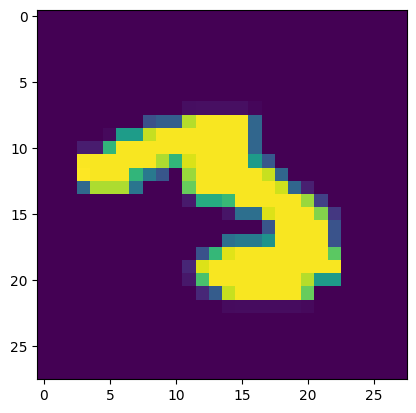

In [5]:
for image, label in train_loader:
    print(image.shape)
    image = image.permute(0, 2, 3, 1)
    print(image.view(64, -1).shape)
    plt.imshow(image[0])
    print(label)
    break

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, 256)
        self.reluL = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 784)
#         self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.reluL(x)
        x = self.linear2(x)
        x = self.reluL(x)
        x = self.linear3(x)
        x = self.tanh(x)
        
        return x

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.reluL = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.reluL(x)
        x = self.linear2(x)
        x = self.reluL(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        
        return x

In [42]:
generator = Generator(100)
discriminator = Discriminator()

noise_input = torch.randn(1, 100)
real_input = train_dataset[0][0].view(1, -1)
print(real_input.shape)
real_labels = torch.ones(1, 1)
fake_labels = torch.zeros(1, 1)

generator_output = generator(noise_input) # image generated from generator
discriminator_output_fake = discriminator(generator_output) # ideally should be 0
discriminator_output_real = discriminator(real_input) # ideally should be 1

# -log(D(x)) - log(1 - D(G(z)))
d_loss = -torch.log(discriminator_output_real) - torch.log(1 - discriminator_output_fake)
print(d_loss)

# -log(1 - D(G(z)))
g_loss = -torch.log(1 - discriminator_output_fake)
print(g_loss)

torch.Size([1, 784])
tensor([[1.4196]], grad_fn=<SubBackward0>)
tensor([[0.7066]], grad_fn=<NegBackward0>)


In [43]:
# first loss: send real labels along with output from real_image --> discriminator
# second loss: send fake labels along with output from fake_image --> discriminator
bce_d_loss = criterion(discriminator_output_real, real_labels) + criterion(discriminator_output_fake, fake_labels)
print(bce_d_loss)

# send real_labels along with fake_image --> discriminator
bce_g_loss = criterion(discriminator_output_fake, real_labels)
print(bce_g_loss)

tensor(1.4196, grad_fn=<AddBackward0>)
tensor(0.6799, grad_fn=<BinaryCrossEntropyBackward0>)


In [110]:
criterion = nn.BCELoss()

device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
generator_opt = optim.Adam(generator.parameters(), lr=0.0002)
discriminator_opt = optim.Adam(discriminator.parameters(), lr=0.0002)

In [108]:
epochs = 80
latent_dim = 100
batch_size = 64

d_losses, g_losses = list(), list()

for epoch in range(epochs):
    discriminator.train(True)
    for images, _ in train_loader:
        real_images = images.view(-1, 28*28).to(device) # Convert image to (B, height*width)
        
        discriminator_opt.zero_grad()
        generator_opt.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device) # Shape: (B, 1). Filled with ones
        fake_labels = torch.zeros(real_images.size(0), 1).to(device) # Shape : (B, 1). Filled with zeros
        
        real_outputs = discriminator(real_images) # Shape: (B, 1)
        d_loss_real = criterion(real_outputs, real_labels)
        
        noise = torch.randn(real_images.size(0), latent_dim).to(device) #Shape: (B, 100)
        fake_images = generator(noise) # Shape: (B, height*width)
        fake_outputs = discriminator(fake_images)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss.item())
        d_loss.backward()
        discriminator_opt.step()
        
        generator_opt.zero_grad()
        discriminator_opt.zero_grad()
        noise = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_losses.append(g_loss)
        
        g_loss.backward()
        generator_opt.step()
        
    if epoch % 5 == 0:
        print(epoch, d_loss, g_loss)

0 tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
5 tensor(1.1320, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
10 tensor(1.0023, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.3838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
15 tensor(0.9386, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
20 tensor(0.9003, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
25 tensor(0.8484, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
30 tensor(1.0002, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
35 tensor(0.9217, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8712, device='cuda:0', g

In [82]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        B, C, height, width = x.shape
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = x.view(B, -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [84]:
mnist_loss = nn.CrossEntropyLoss()

clf = MnistClassifier().to(device)
opt = optim.Adam(clf.parameters(), lr=0.0002)
epochs = 10


for epoch in range(epochs):
    clf.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = images.shape[0]
        
        output = clf(images)
        opt.zero_grad()
        loss = mnist_loss(output, labels)
        
        
        loss.backward()
        opt.step()
        
    
        
    print(f'{epoch} :: {loss}')
    
    
clf.eval()
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = clf(images)
        
        match = (torch.max(output, dim=-1)[1] == labels).sum()
        correct += match
        
print(correct)

0 :: 0.1393672227859497
1 :: 0.032995447516441345
2 :: 0.1703263819217682
3 :: 0.06815735995769501
4 :: 0.2562086582183838
5 :: 0.01570613496005535
6 :: 0.044376175850629807
7 :: 0.06644117832183838
8 :: 0.018148379400372505
9 :: 0.13869215548038483


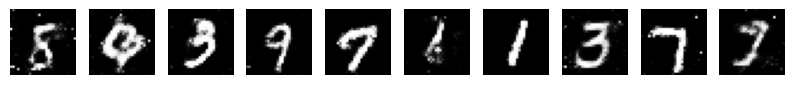

In [125]:
num_samples = 10
noise = torch.randn(num_samples, latent_dim).to(device)
fake_images = generator(noise).cpu().detach().numpy()

plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [119]:
#(torch.sum(-torch.log(prediction_real) - torch.log(1 - prediction_generated)))
-torch.log(prediction_real) - torch.log(1 - prediction_generated)


tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0', grad_fn=<SubBackward0>

In [127]:
epochs = 100
steps = 10
batch_size = 64
latent_dim = 32

device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
generator_opt = optim.Adam(generator.parameters(), lr=0.0002)
discriminator_opt = optim.Adam(discriminator.parameters(), lr=0.0002)

for epoch in range(epochs):
    discriminator_loss = 0
    generator_loss = 0
    for images, labels in train_loader:
        batch_size = images.shape[0]
        noise = torch.randn(batch_size, latent_dim)
        real_data = images.view(batch_size, -1)
        noise, real_data = noise.to(device), real_data.to(device)
#         print(f'Shape of noise and real data is {noise.shape} and {real_data.shape}')
        
        generator_opt.zero_grad()
        discriminator_opt.zero_grad()
        generator.eval()
        discriminator.train(True)
        
        generated_image = generator(noise)
        prediction_real = discriminator(real_data)
        prediction_generated = discriminator(generated_image)
        
        loss_discriminator = (torch.sum(-torch.log(prediction_real) - torch.log(1 - prediction_generated))) / batch_size
        discriminator_loss += loss_discriminator
        
        loss_discriminator.backward()
        discriminator_opt.step()

        generator_opt.zero_grad()
        discriminator_opt.zero_grad()
        discriminator.eval()
        generator.train(True)

        generated_image = generator(noise)
#         print(f'Shape of generated image for training generator is {generated_image.shape}')
#         loss_generator = -torch.sum(-torch.log(1 - discriminator(generated_image))) / batch_size
        loss_generator = torch.sum(-torch.log(discriminator(generated_image))) / batch_size # works
        generator_loss += loss_generator
        loss_generator.backward()
        generator_opt.step()
        
    if epoch % 5==0:
        print(epoch, loss_generator, loss_discriminator)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [29]:
generator_loss.cpu().detach().numpy(), discriminator_loss.cpu().detach().numpy()

(array(-569.2147, dtype=float32), array(1112.8075, dtype=float32))

In [25]:
noise = torch.randn(1, latent_dim).to(device)
print(noise.shape)

generated = generator(noise)
print(generated.shape)

torch.Size([1, 32])
torch.Size([1, 784])


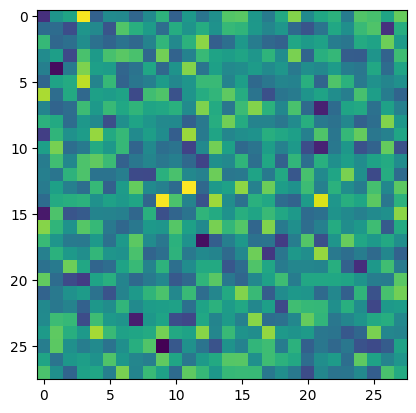

In [26]:
# plt.imshow(generated.view(1, 28, 28).cpu().detach().numpy())
plt.imshow(generated.view(1, 28, 28).cpu().detach().permute(1, 2, 0).numpy())